In [1]:
#Librerías
import sys
import os
import pathlib
import math
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.python.keras as tfk
import numpy as np
import sklearn as sk
import seaborn as sns
import missingno as msno
import patsy
import statsmodels.api as sm
import random
import shap
import lime

#Funciones
from pathlib import Path
from math import ceil
from numpy import abs, logical_and, nan
from pandas import read_csv, DataFrame, get_dummies
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import OneClassSVM, SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from scipy.stats.mstats import winsorize
from scipy.stats import expon, reciprocal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from lime.lime_tabular import LimeTabularExplainer

#Texto centrado
from IPython.core.display import HTML

HTML("""
<style>
    p {
        text-align: justify;
    }
</style>
""")


def printVersion(obj, name):
  if hasattr(obj, '__version__'):
    return f'{name} version: {obj.__version__} \n\n'
  else:
    return f'{name} no tiene un atributo __version__.\n\n'


print(
    printVersion(tf, 'TensorFlow'),
    printVersion(mpl, 'Matplotlib'),
    printVersion(pd, 'Pandas'),
    printVersion(tfk, 'Keras'),
    printVersion(np, 'Numpy'),
    printVersion(sk, 'Sklearn'),
    printVersion(sns, 'Seaborn'),
    printVersion(msno, 'Missingno')
)

print()

TensorFlow version: 2.16.1 

 Matplotlib version: 3.7.2 

 Pandas version: 2.0.3 

 Keras no tiene un atributo __version__.

 Numpy version: 1.24.3 

 Sklearn version: 1.3.0 

 Seaborn version: 0.12.2 

 Missingno version: 0.5.2 





In [2]:
new_directory = 'C:/Users/artem/Desktop/IML'

os.chdir(new_directory)

dataset = read_csv('student-mat.csv', sep=';', decimal='.')

print(dataset ,'\n\n\n\n\n')

print(dataset.info())

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... famrel freetime  goout  Dalc  Walc health 

In [3]:
#Separación del Dataset en variables numéricas y categóricas

for column in dataset:
  if dataset[column].dtype == 'object':
    dataset[column] = dataset[column].astype('category')

print(dataset.info());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      395 non-null    category
 1   sex         395 non-null    category
 2   age         395 non-null    int64   
 3   address     395 non-null    category
 4   famsize     395 non-null    category
 5   Pstatus     395 non-null    category
 6   Medu        395 non-null    int64   
 7   Fedu        395 non-null    int64   
 8   Mjob        395 non-null    category
 9   Fjob        395 non-null    category
 10  reason      395 non-null    category
 11  guardian    395 non-null    category
 12  traveltime  395 non-null    int64   
 13  studytime   395 non-null    int64   
 14  failures    395 non-null    int64   
 15  schoolsup   395 non-null    category
 16  famsup      395 non-null    category
 17  paid        395 non-null    category
 18  activities  395 non-null    category
 19  nursery 

**Exploratory Data Analysis**

*Parte 1 - Variables Categóricas*

In [4]:
categorical_variables = dataset.select_dtypes(include='category')
print(categorical_variables)
print(categorical_variables.shape)

for catColumn in categorical_variables:
  categorias = dataset[catColumn].cat.categories
  categoriasP = []
  for categoria in categorias:
    categoriasP.append(categoria)
  categoriasP = ' | '.join(map(str, categoriasP))
  print(f'Los posibles valores para la categoria {catColumn.upper()} son: \t\t{categoriasP}')


  print('')

    school sex address famsize Pstatus      Mjob      Fjob  reason guardian  \
0       GP   F       U     GT3       A   at_home   teacher  course   mother   
1       GP   F       U     GT3       T   at_home     other  course   father   
2       GP   F       U     LE3       T   at_home     other   other   mother   
3       GP   F       U     GT3       T    health  services    home   mother   
4       GP   F       U     GT3       T     other     other    home   father   
..     ...  ..     ...     ...     ...       ...       ...     ...      ...   
390     MS   M       U     LE3       A  services  services  course    other   
391     MS   M       U     LE3       T  services  services  course   mother   
392     MS   M       R     GT3       T     other     other  course    other   
393     MS   M       R     LE3       T  services     other  course   mother   
394     MS   M       U     LE3       T     other   at_home  course   father   

    schoolsup famsup paid activities nursery higher

In [5]:
#Descripción de las variables categóricas
print(categorical_variables.describe().T)

print()

           count unique     top freq
school       395      2      GP  349
sex          395      2       F  208
address      395      2       U  307
famsize      395      2     GT3  281
Pstatus      395      2       T  354
Mjob         395      5   other  141
Fjob         395      5   other  217
reason       395      4  course  145
guardian     395      3  mother  273
schoolsup    395      2      no  344
famsup       395      2     yes  242
paid         395      2      no  214
activities   395      2     yes  201
nursery      395      2     yes  314
higher       395      2     yes  375
internet     395      2     yes  329
romantic     395      2      no  263



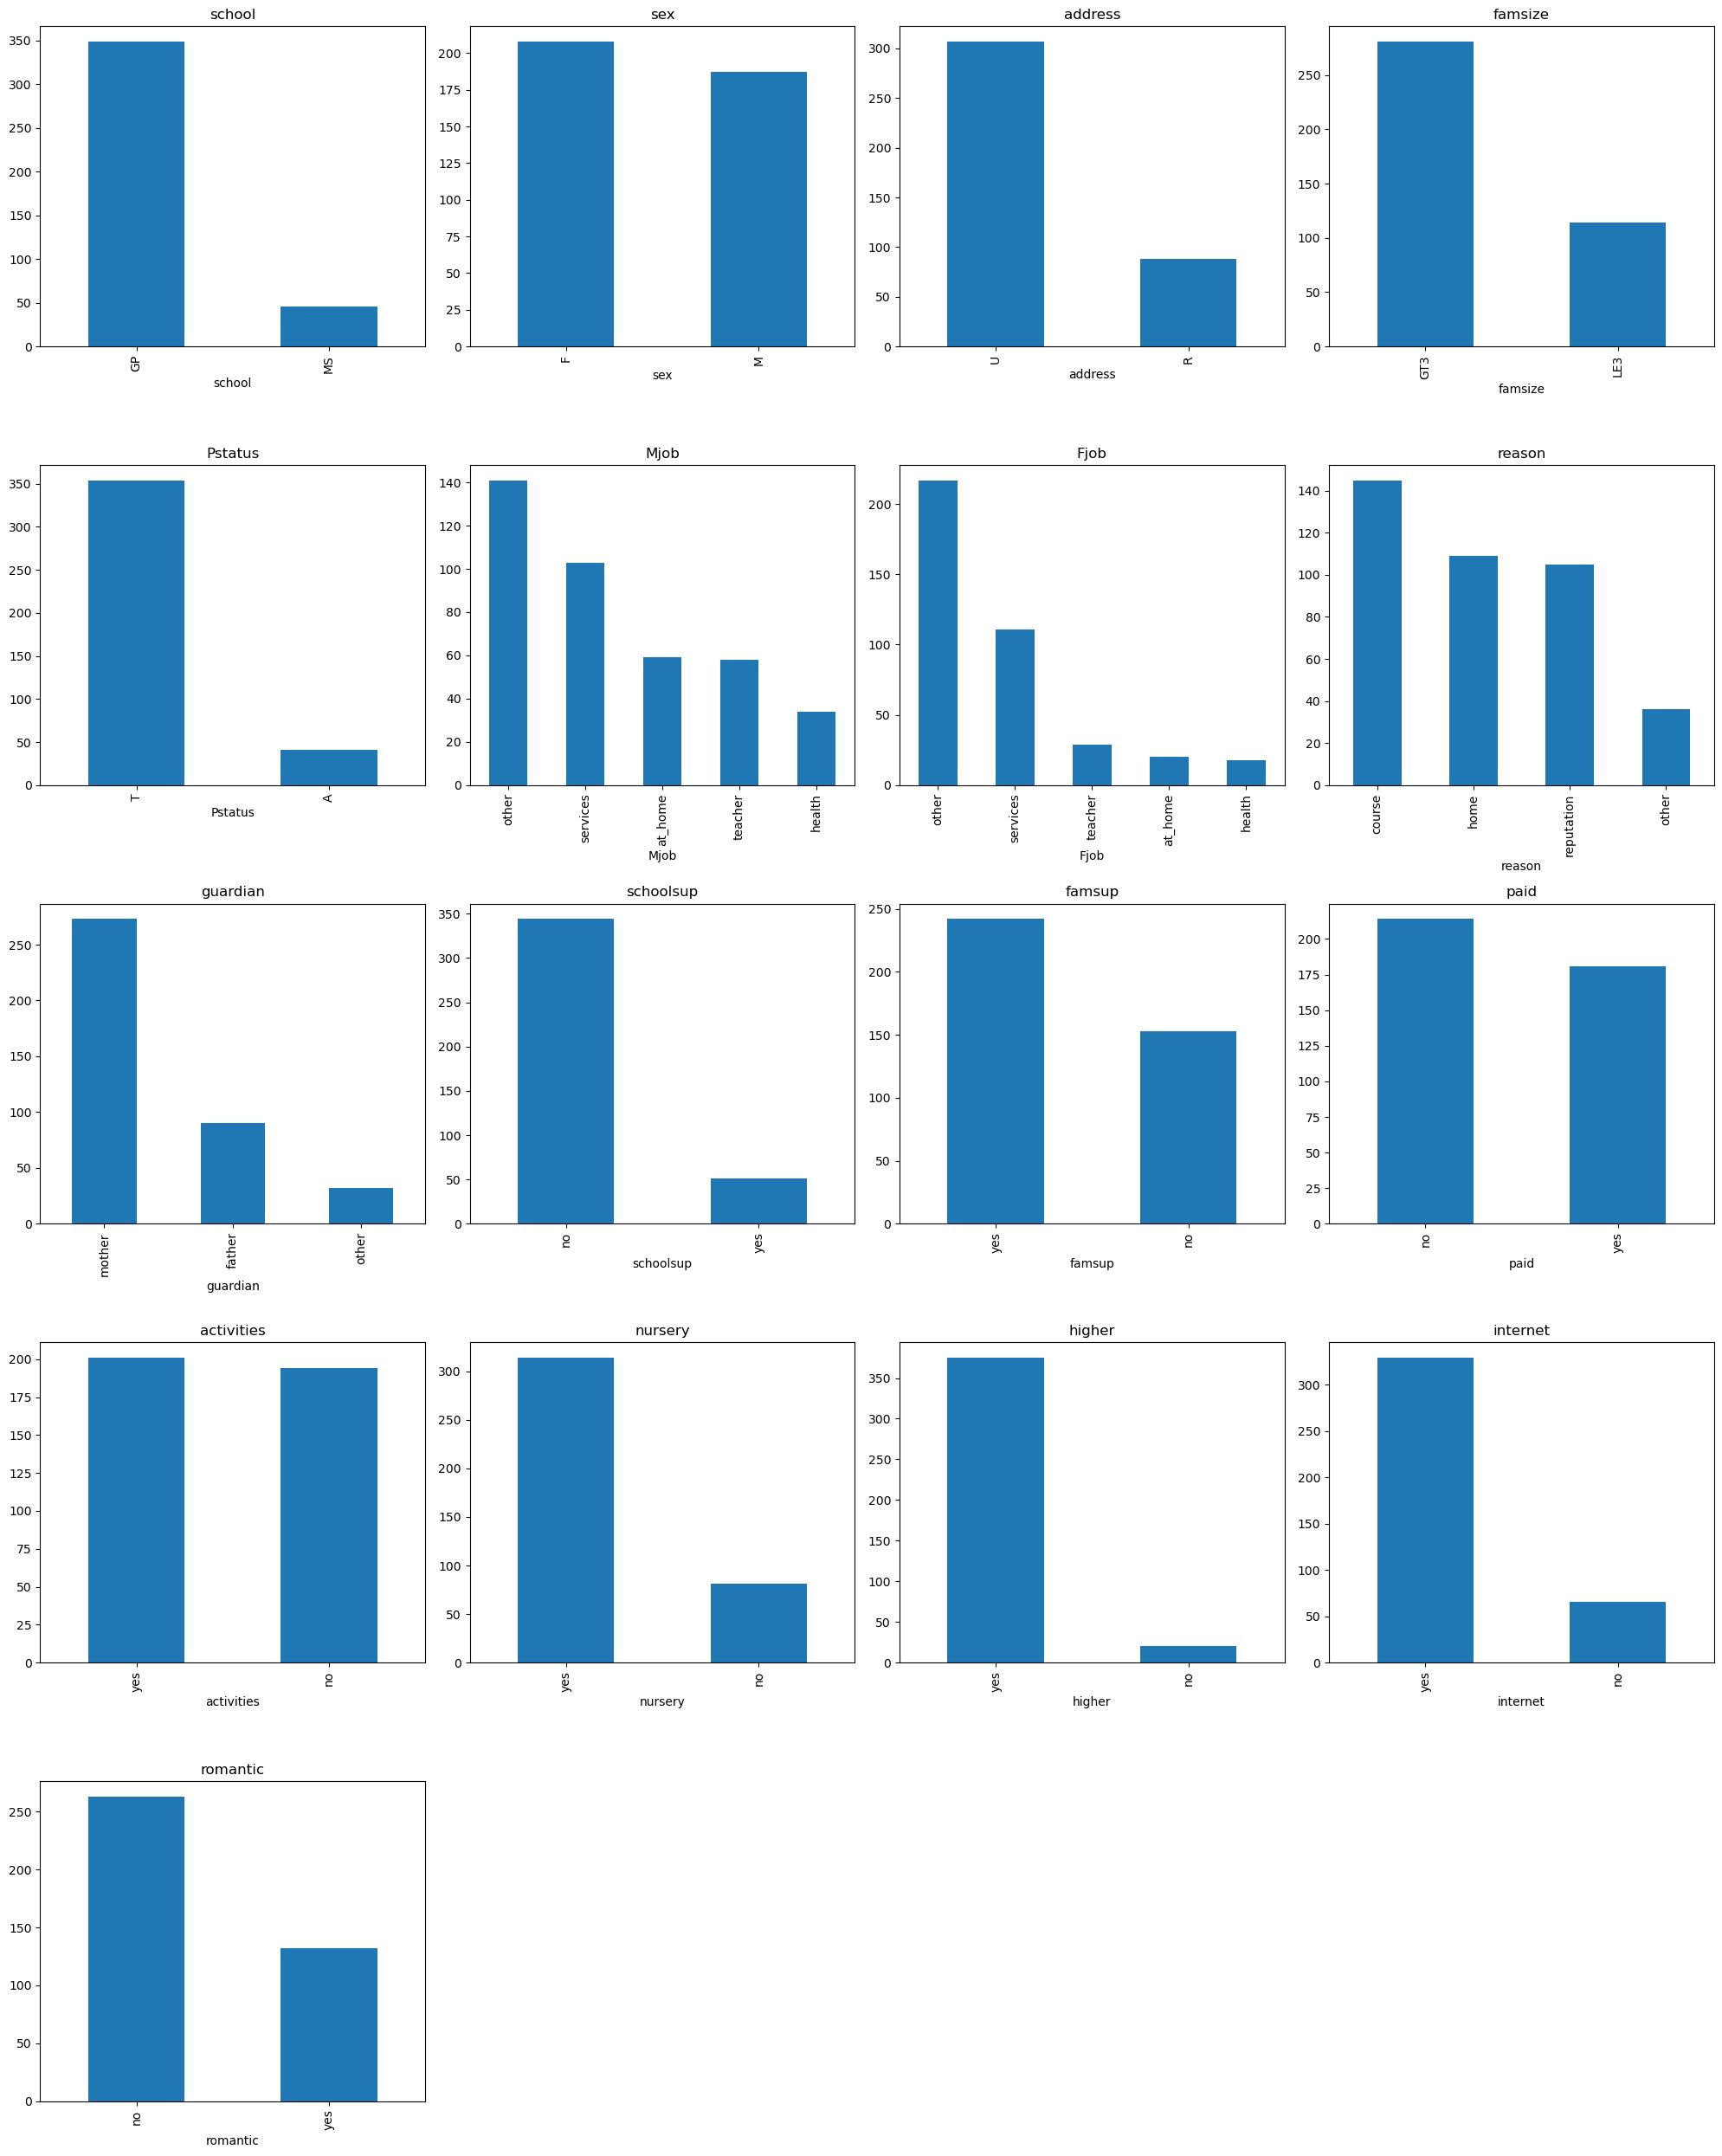

In [6]:
num_columns = 4
num_rows = int(np.ceil(len(categorical_variables.columns) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))

for i, cat in enumerate(categorical_variables.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    categorical_variables[cat].value_counts().plot.bar(ax=ax)
    ax.set_title(cat)

for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

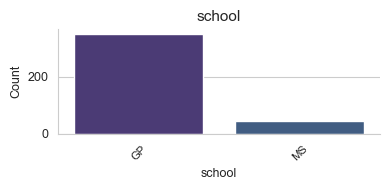

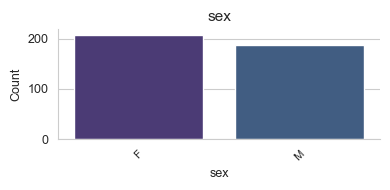

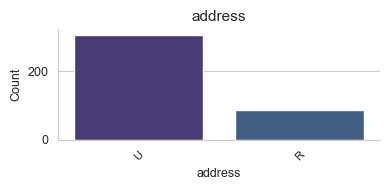

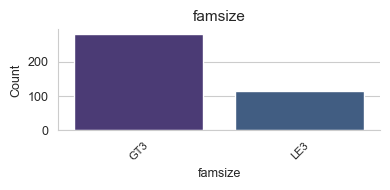

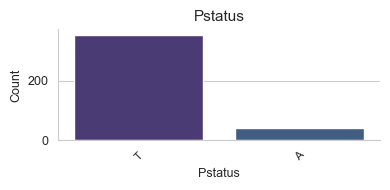

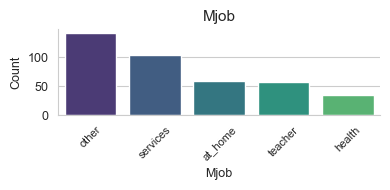

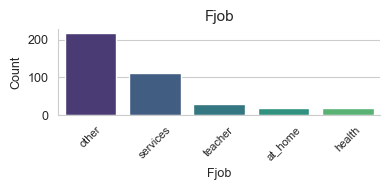

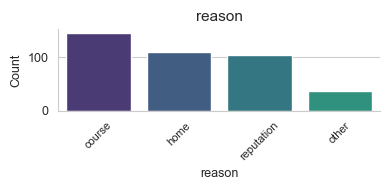

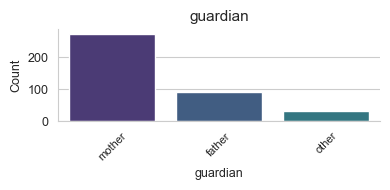

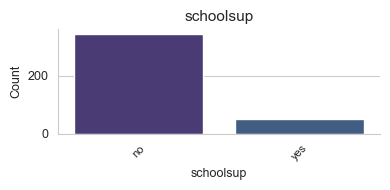

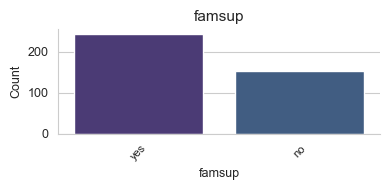

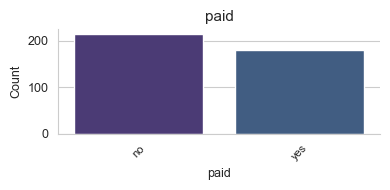

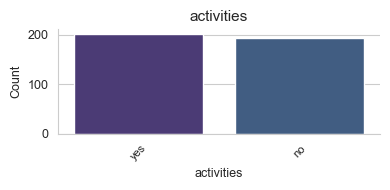

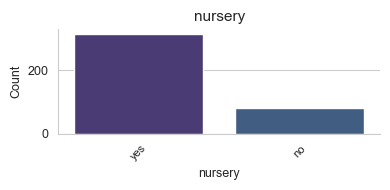

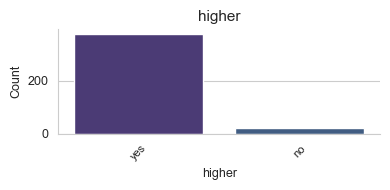

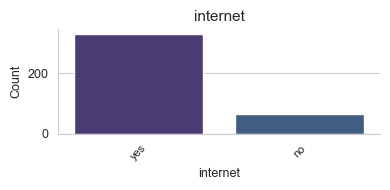

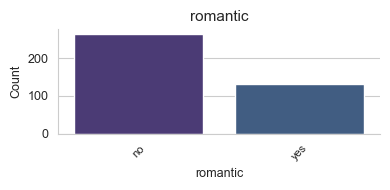

In [7]:
#Alternativamente - Lo Mismo - En Seaborn

sns.set_style("whitegrid")
sns.set_palette("viridis")

for cat in categorical_variables.columns:
    plt.figure(figsize=(4, 2))

    sns.countplot(data=categorical_variables, x=cat, order=categorical_variables[cat].value_counts().index)

    plt.title(cat, fontsize=11)
    plt.xlabel(cat, fontsize=9)
    plt.ylabel('Count', fontsize=9)
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=9)
    sns.despine()

    plt.tight_layout()
    plt.show()
    print()

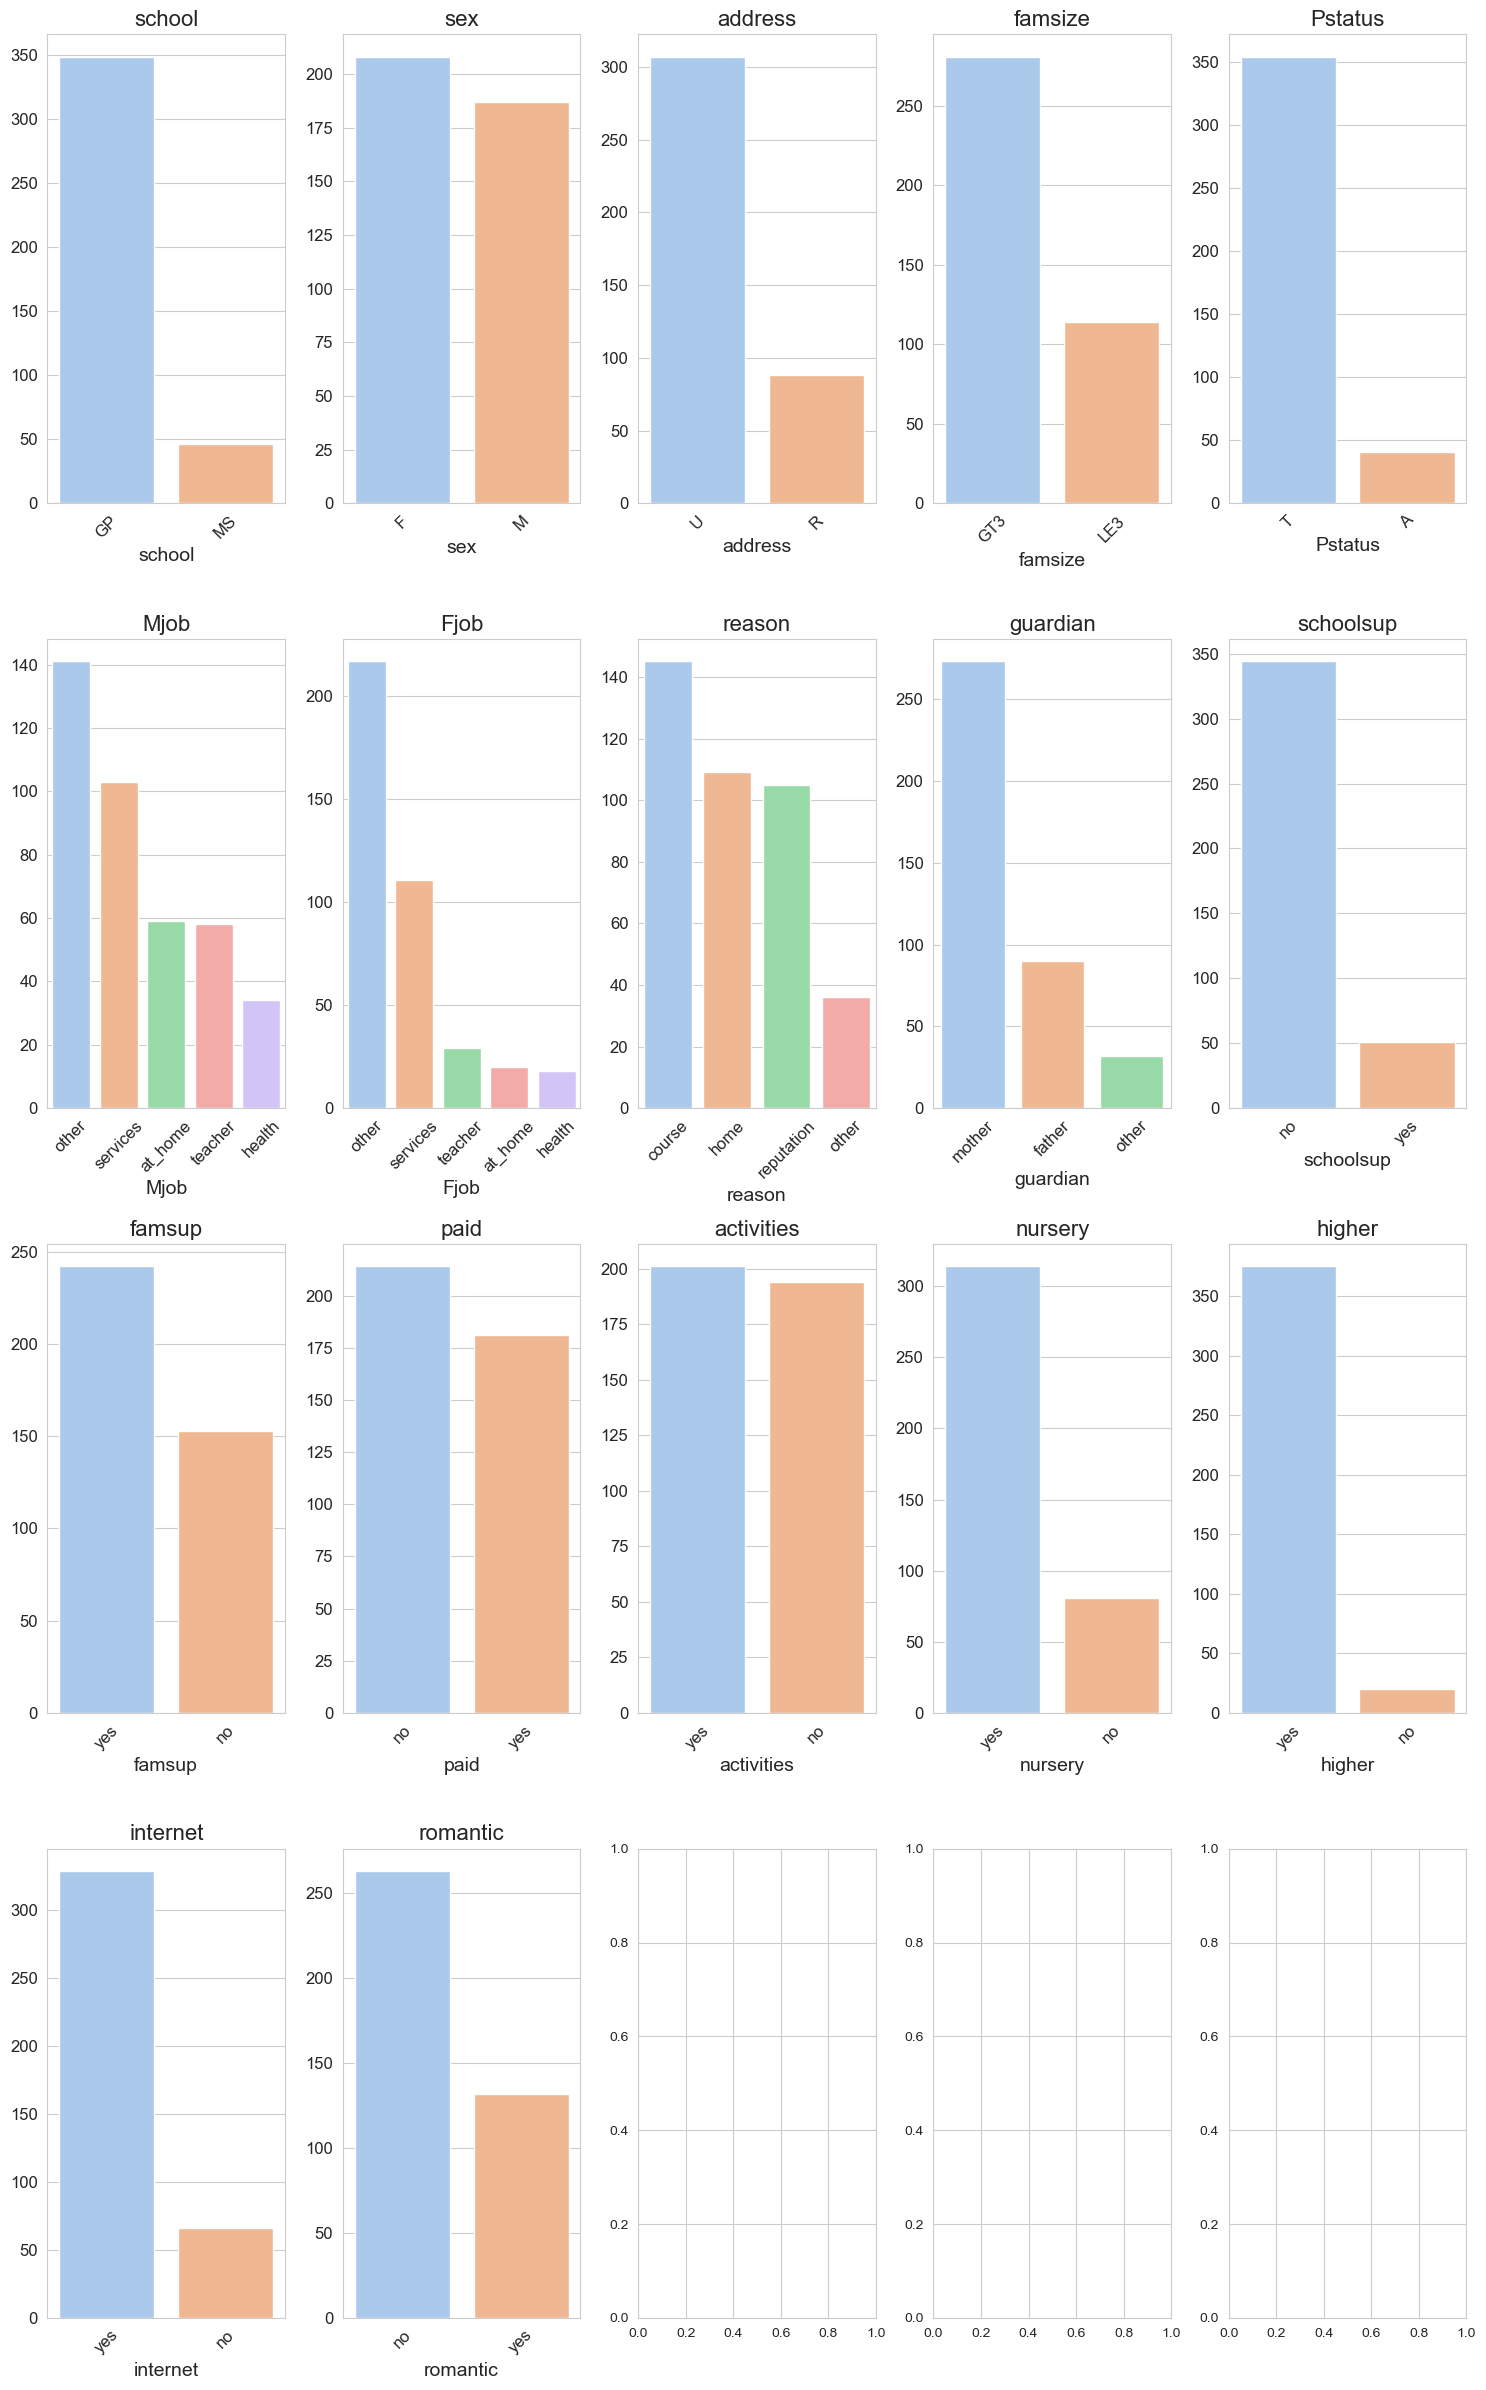

In [8]:
sns.set_style("whitegrid")
sns.set_palette("pastel")
n_cols = 5
n_rows = ceil(categorical_variables.columns.size / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))

for i, cat in enumerate(categorical_variables.columns):
    row = i // n_cols
    col = i % n_cols

    sns.countplot(data=categorical_variables, x=cat, ax=axs[row][col], order=categorical_variables[cat].value_counts().index)

    axs[row][col].set_title(cat, fontsize=16)
    axs[row][col].set_xlabel(cat, fontsize=14)
    axs[row][col].set_ylabel('', fontsize=14)
    axs[row][col].tick_params(axis='x', rotation=45, labelsize=12)
    axs[row][col].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

*Parte 2 - Variables Numéricas*

In [9]:
def showInfo(catName, data):
  print(f'\n\n {catName}')
  print("---------------------------------------------------------------------------------------------------------- \n\n")
  print(data)

nums_values = dataset.select_dtypes(include = 'number')

showInfo('INFO GENERAL VARIABLES NUMERICAS',nums_values)
showInfo('DESCRIPCION DE LAS VARIABLES NUMERICAS',nums_values.describe().T)
showInfo('CORRELACIONES DE LAS VARIABLES NUMERICAS',nums_values.corr())

#El método default en Python es Pearson

#Añadimos el método Spearman para captar tanto las relaciones lineales como no lineales

showInfo('CORRELACIONES SPEARMAN', nums_values.corr(method='spearman'))



 INFO GENERAL VARIABLES NUMERICAS
---------------------------------------------------------------------------------------------------------- 


     age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
0     18     4     4           2          2         0       4         3   
1     17     1     1           1          2         0       5         3   
2     15     1     1           1          2         3       4         3   
3     15     4     2           1          3         0       3         2   
4     16     3     3           1          2         0       4         3   
..   ...   ...   ...         ...        ...       ...     ...       ...   
390   20     2     2           1          2         2       5         5   
391   17     3     1           2          1         0       2         4   
392   21     1     1           1          1         3       5         5   
393   18     3     2           3          1         0       4         4   
394   19     1     1         

In [10]:
#Correlaciones Pearson

def showRelevantCorrsPearson(higher, lower):
  corrMatrixPearson = nums_values.corr()
  correlacionesAltasPearson = corrMatrixPearson[(corrMatrixPearson > higher) & (corrMatrixPearson <= 1)]
  correlacionesBajasPearson = corrMatrixPearson[(corrMatrixPearson < lower) & (corrMatrixPearson >= -1)]
  return [correlacionesAltasPearson, correlacionesBajasPearson]

def cleaningCorrsPearson(corr):

  return corr.unstack().sort_values().drop_duplicates().dropna();


relevant_pearson = showRelevantCorrsPearson(0.5, -0.2)
print('CORRELACIONES DIRECTAS MÉTODO DE PEARSON \n\n',cleaningCorrsPearson(relevant_pearson[0]),
      '\n\n\nCORRELACIONES INVERSAS MÉTODO DE PEARSON \n\n', cleaningCorrsPearson(relevant_pearson[1]))

CORRELACIONES DIRECTAS MÉTODO DE PEARSON 

 Medu  Fedu    0.623455
Dalc  Walc    0.647544
G3    G1      0.801468
G2    G1      0.852118
      G3      0.904868
      G2      1.000000
dtype: float64 


CORRELACIONES INVERSAS MÉTODO DE PEARSON 

 failures   G3         -0.360415
           G2         -0.355896
           G1         -0.354718
studytime  Walc       -0.253785
Fedu       failures   -0.250408
Medu       failures   -0.236680
dtype: float64


In [11]:
#Correlaciones Spearman

def showRelevantCorrsSpearman(higher, lower):
  corrMatrixSpearman = nums_values.corr(method='spearman')
  correlacionesAltasSpearman = corrMatrixSpearman[(corrMatrixSpearman > higher) & (corrMatrixSpearman <= 1)]
  correlacionesBajasSpearman = corrMatrixSpearman[(corrMatrixSpearman < lower) & (corrMatrixSpearman >= -1)]
  return [correlacionesAltasSpearman, correlacionesBajasSpearman]

def cleaningCorrsSpearman(corr):

  return corr.unstack().sort_values().drop_duplicates().dropna();


relevant_spearman = showRelevantCorrsSpearman(0.5, -0.2)
print('CORRELACIONES DIRECTAS MÉTODO DE SPEARMAN \n\n',cleaningCorrsSpearman(relevant_spearman[0]),
      '\n\n\nCORRELACIONES INVERSAS MÉTODO DE SPEARMAN \n\n', cleaningCorrsSpearman(relevant_spearman[1]))

CORRELACIONES DIRECTAS MÉTODO DE SPEARMAN 

 Medu  Fedu    0.631577
Dalc  Walc    0.639906
G3    G1      0.878001
G2    G1      0.894792
      G3      0.957125
      G2      1.000000
dtype: float64 


CORRELACIONES INVERSAS MÉTODO DE SPEARMAN 

 failures   G2         -0.362357
           G3         -0.361224
           G1         -0.346052
studytime  Walc       -0.264021
Medu       failures   -0.242373
Fedu       failures   -0.236616
studytime  Dalc       -0.217904
dtype: float64


Si bien es bueno y útil comprobar tanto las posibles relaciones lineales como no lineales, podemos observar que no hay una diferencia significativa en los coeficientes obtenidos de forma general (aunque hay algunas excepciones).

De esta forma, podemos observar:

1 - Notas.

Codificadas como G1 (Primer Período), G2 (Segundo Período) y G3 (Nota Final). 

Correlación directa muy alta entre G1 (igual a 0.85) y G2, y correlación todavía más alta entre G2 (0.90 según el método de Pearson y 0.95 según el método de Spearman) y G3.

Mientras que la correlación directa entre G1 y G3 es muy alta (igual a 0.80), es cierto también que, como hemos visto antes, influye más G2 (Segundo Período) a efectos de la Nota Final.

2 - Notas y Fracasos.

Resulta interesante observar que, en cuanto a la correlación inversa, el número de fracasos afecta negativamente de una forma muy similar (en -0.35 para G1, G2 y G3, con apenas pequeñas variaciones decimales de diferencia).

3 - Consumo de alcohol.

Observamos que el consumo de alcohol entre semana (variable DALC) y los fines de semana (variable WALC) está directamente correlacionado en apróximadamente dos tercios (el coeficiente es igual a 0.65).

4 - Consumo de alcohol y tiempo de estudio.

Se puede ver una ligera correlación negativa lineal entre el consumo de alcohol los fines de semana y el tiempo de estudio (de -0.25), así como una correlación negativa de Spearman de -0.21 en cuanto al consumo de alcohol entre semana y el tiempo de estudio.

5 - Educación de la madre y la del padre.

Variables (MEDU y FEDU) codificadas en 5 niveles (0 = sin educación, 1 = más bajo, 4 = más alto).

Hay una correlación directa positiva (igual a 0.62).

6 - Educación padres y fracasos.

En ambos casos hay una correlación negativa de -0.25 con la variable 'failures'.

Teniendo en cuenta la presencia de niveles, sería conveniente explorar esta dependencia más en detalle.

A continuación pues, vamos a explorar algunas de las correlaciones más significativas, que han sido descritas previamente:

Edad del estudiante
numérica: de 15 a 22


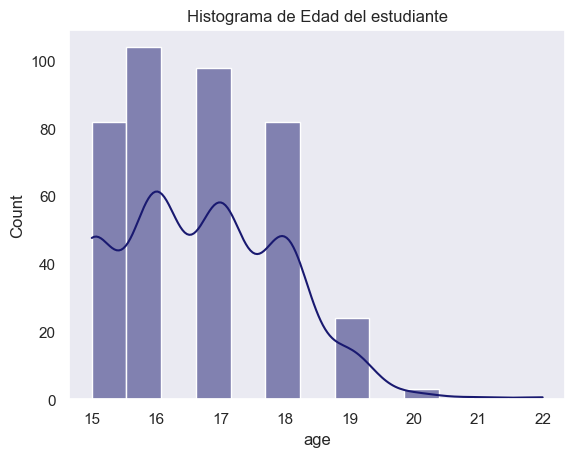

Educación de la madre
numérica: 0 - ninguna, 1 - educación primaria (4to grado), 2 - 5to a 9no grado, 3 - educación secundaria, 4 - educación superior


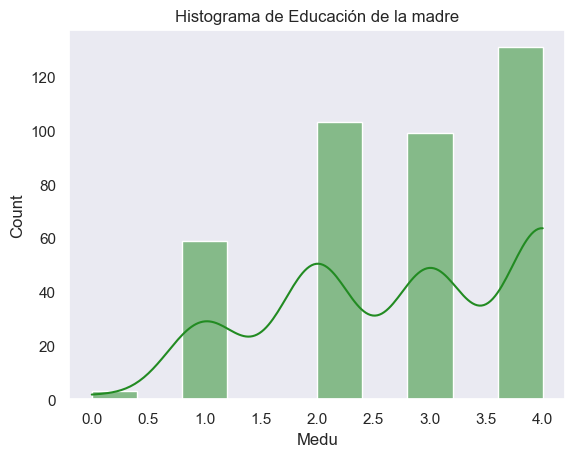

Educación del padre
numérica: 0 - ninguna, 1 - educación primaria (4to grado), 2 - 5to a 9no grado, 3 - educación secundaria, 4 - educación superior


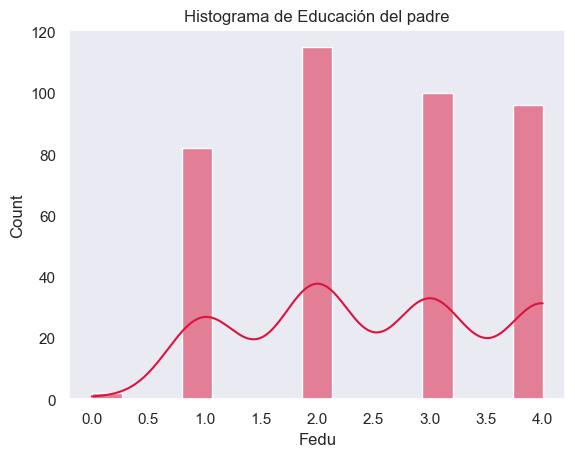

Tiempo de estudio semanal
numérica: 1 - <2 horas, 2 - 2 a 5 horas, 3 - 5 a 10 horas, 4 - >10 horas


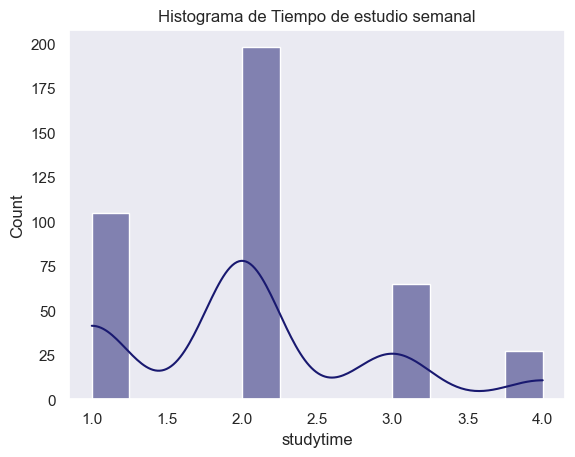

Número de fracasos en clases anteriores
numérica: n si 1<=n<3, de lo contrario 4


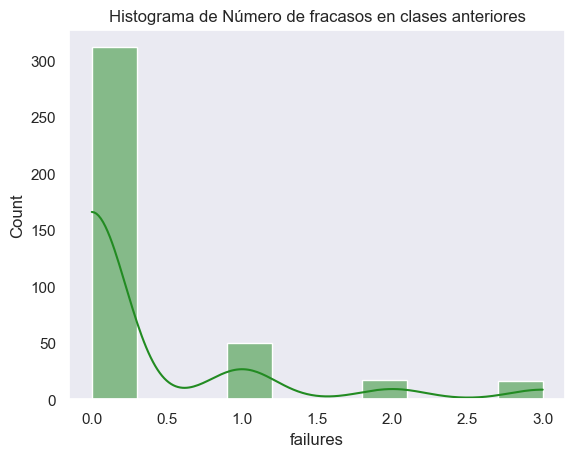

Consumo de alcohol entre semana
numérica: de 1 - muy bajo a 5 - muy alto


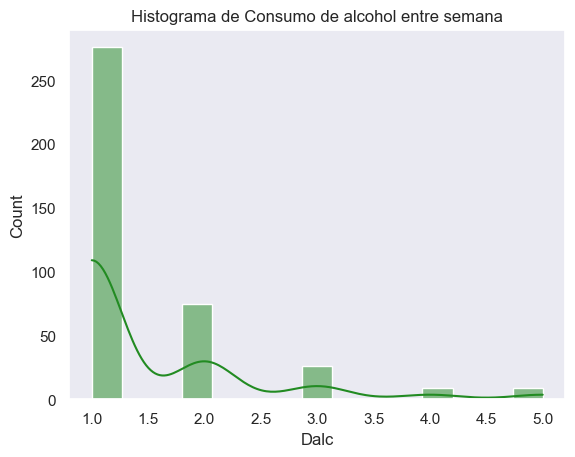

Consumo de alcohol los fines de semana
numérica: de 1 - muy bajo a 5 - muy alto


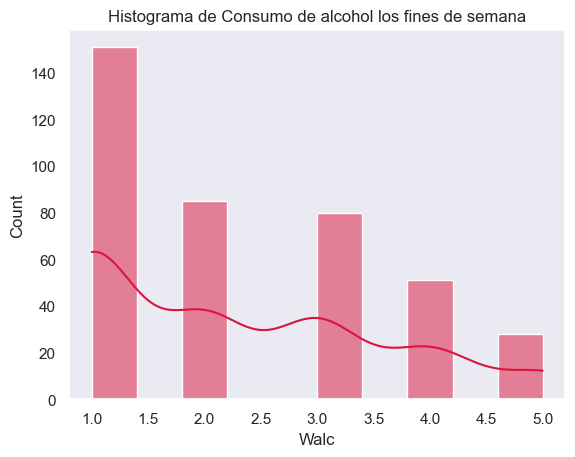

Nota del primer período
numérica: de 0 a 20


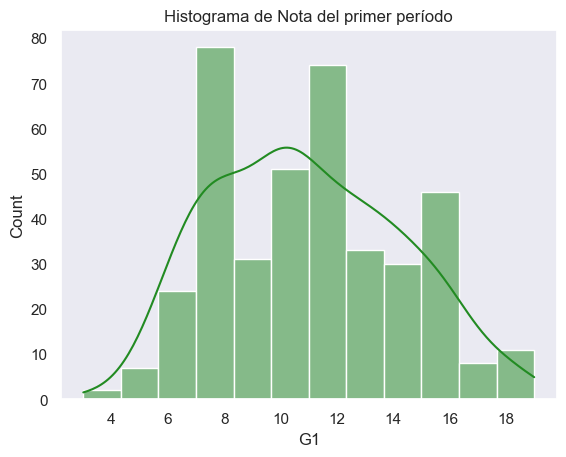

Nota del segundo período
numérica: de 0 a 20


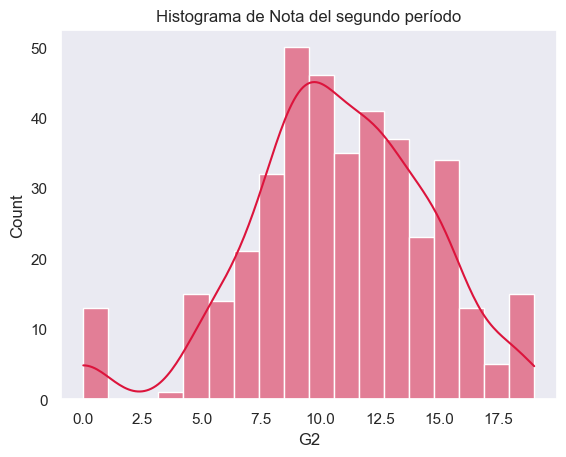

Nota final
objetivo de salida, numérica: de 0 a 20


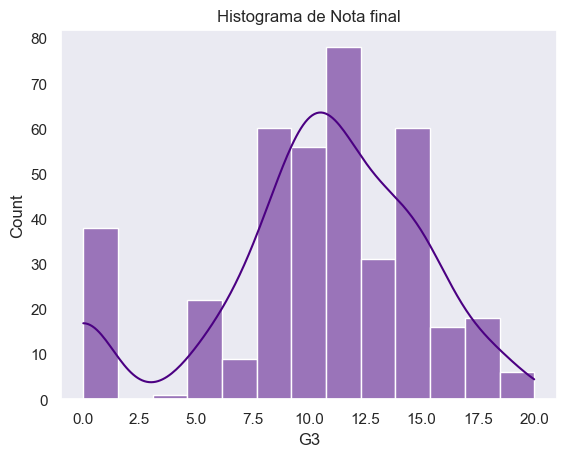

In [12]:
titles = {
    "age": ["Edad del estudiante", "numérica: de 15 a 22"],
    "Medu": ["Educación de la madre", "numérica: 0 - ninguna, 1 - educación primaria (4to grado), 2 - 5to a 9no grado, 3 - educación secundaria, 4 - educación superior"],
    "Fedu": ["Educación del padre", "numérica: 0 - ninguna, 1 - educación primaria (4to grado), 2 - 5to a 9no grado, 3 - educación secundaria, 4 - educación superior"],
    "studytime": ["Tiempo de estudio semanal", "numérica: 1 - <2 horas, 2 - 2 a 5 horas, 3 - 5 a 10 horas, 4 - >10 horas"],
    "failures": ["Número de fracasos en clases anteriores", "numérica: n si 1<=n<3, de lo contrario 4"],
    "Dalc": ["Consumo de alcohol entre semana", "numérica: de 1 - muy bajo a 5 - muy alto"],
    "Walc": ["Consumo de alcohol los fines de semana", "numérica: de 1 - muy bajo a 5 - muy alto"],
    "G1": ["Nota del primer período", "numérica: de 0 a 20"],
    "G2": ["Nota del segundo período", "numérica: de 0 a 20"],
    "G3": ["Nota final", "objetivo de salida, numérica: de 0 a 20"],
    "outlier": ["Indica si es outlier", "1 para valores que no lo son, -1 para valores outliers"]
}

colors = ['midnightblue', 'forestgreen', 'crimson', 'indigo']

#Omitimos algunas variables a fin de mostrar sólo las más relevantes
skip_keys = ["traveltime", "famrel", "freetime", "goout", "health", "absences"]  

for i, n in enumerate(nums_values):
    if n in skip_keys:
        continue
        
    sns.set_theme(style='dark') 
    print(titles[n][0]) 
    print(titles[n][1]) 

    sns.histplot(nums_values[n], kde=True, color=colors[i%4]) 
    plt.title(f'Histograma de {titles[n][0]}') 
    plt.show()

En base a los histogramas anteriores, podemos sacar las siguientes conclusiones:

1 - Edad del estudiante.

Los estudiantes están concentrados en la franja de edad de 15 a 18 años, ambos inclusive. Hay una presencia relativamente baja de estudiantes de 19 años, y apenas no hay de los de 20 - 22 años.

2 - Educación padres.

Se puede ver que las madres tienen en términos generales más nivel educativo que los padres (hombres), con mayor prevalencia de estudios universitarios.

En cuanto a la naturaleza del propio dataset, se puede decir que éste otorga una representividad un tanto desproporcionada a los estudios primarios.

Esto quiere decir que, en realidad, los padres (tanto mujeres como hombres) que poseen estudios universitarios son en realidad muy pocos.

3 - Tiempo de estudio semanal.

Es generalmente muy bajo, siendo la mayor frecuencia la de 2 horas de estudio semanal y tendiendo a menos (1 hora) en bastante casos. El número de alumnos que dedica 3 horas es infrecuente, y apenas hay alumnos que dediquen 4 horas.

4 - Número de fracasos.

A pesar de las estadísticas anteriores, podemos ver que el número de fracasos es casi inexistente.

5 - Consumo de alcohol.

Como hemos visto anteriormente en el análisis de correlaciones, el consumo de alcohol es bastante bajo. Aunque es más habitual que los estudiantes lo consuman los fines de semana.

6 - Notas.

Por lo general, se observa una distribución que tiende a la normal en los 3 casos. Si bien hay una frecuencia relativamente importante de ceros en G2 (Segundo Período). Podemos inferir que este factor incide sobre la Nota Final, puesto que existe una cantidad relativamente importante de ceros también en la frecuencia de esta distribución.

Podremos ver detalles como los de las Notas con mayor precisión si utilizamos el Diagrama de Bigotes. Aparte de mostrar la media y la mediana, esto nos servirá también para identificar outliers de cara al proceso de limpiado de datos:

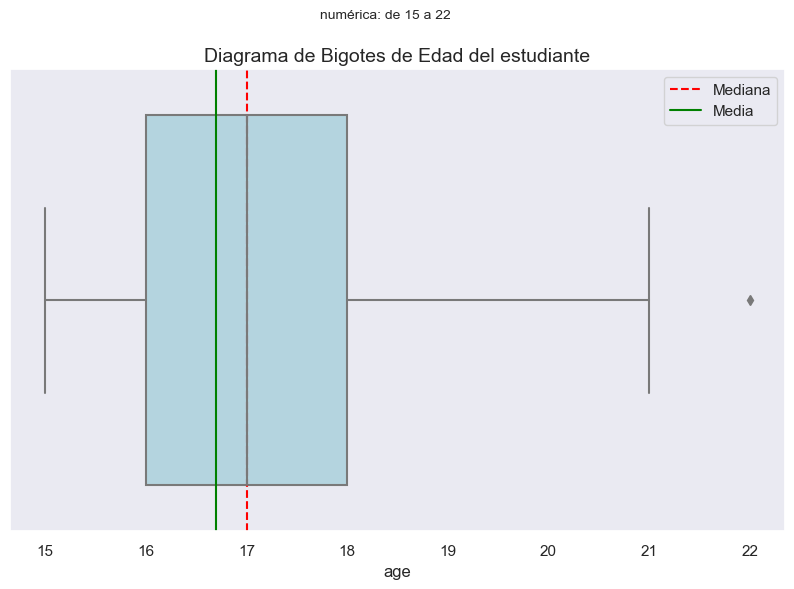

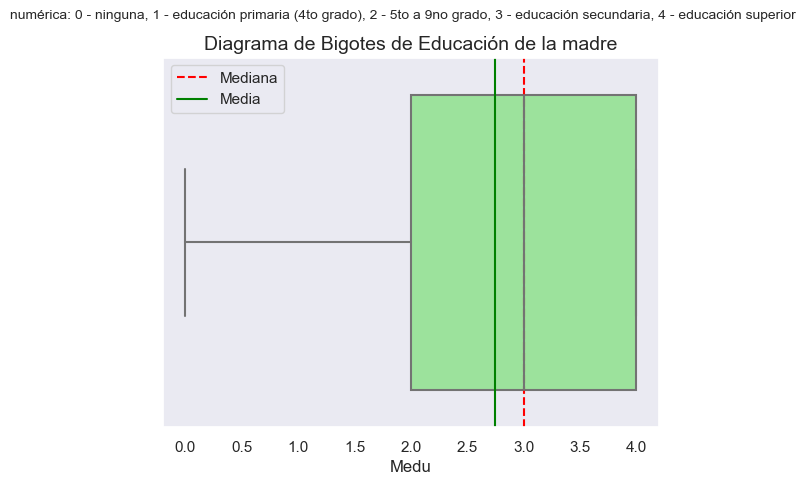

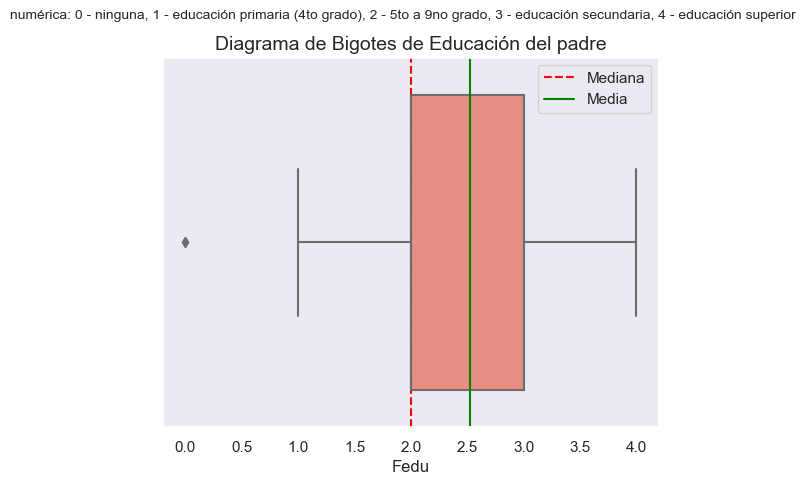

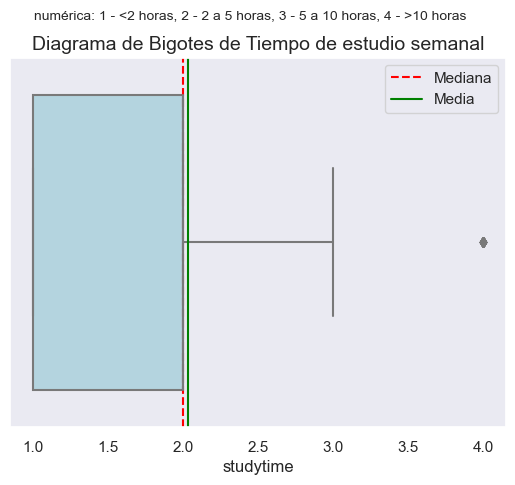

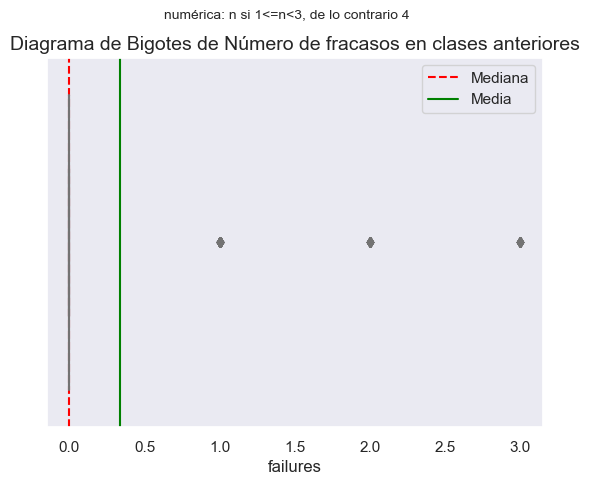

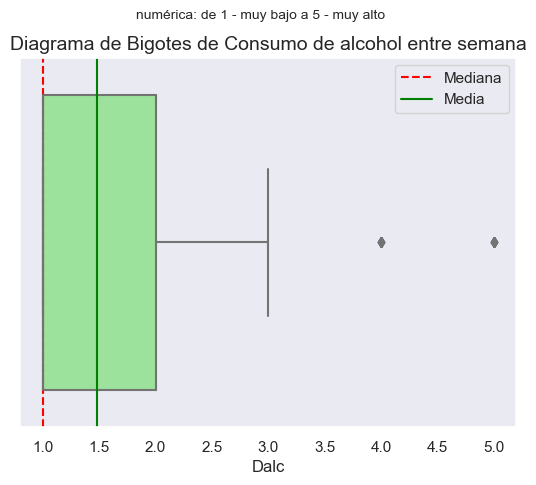

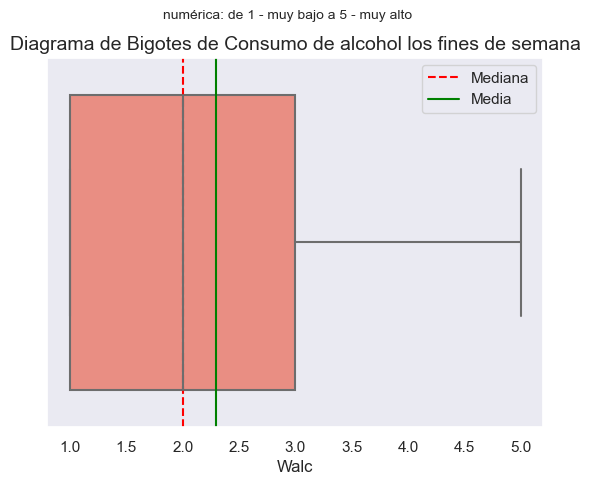

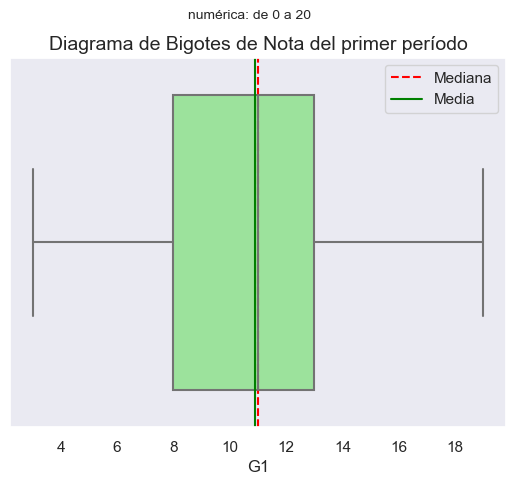

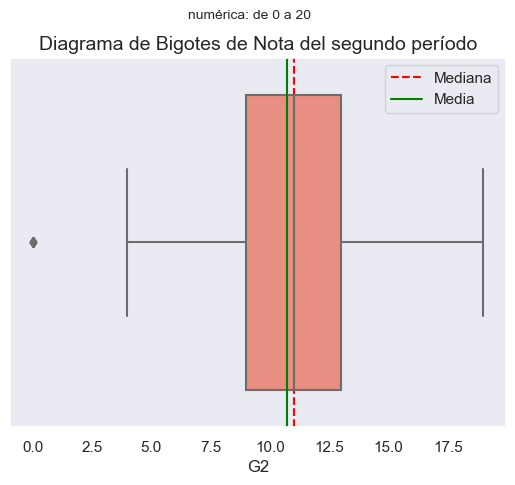

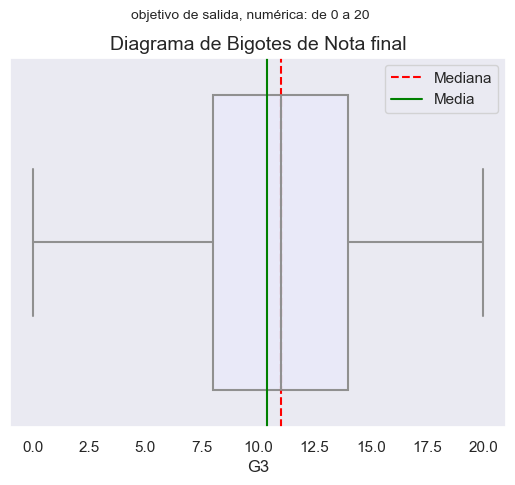

In [13]:
light_colors = ['lightblue', 'lightgreen', 'salmon', 'lavender']

plt.figure(figsize=(10, 6))

skip_keys = ["traveltime", "famrel", "freetime", "goout", "health", "absences"]  

for i, n in enumerate(nums_values):
    if n in skip_keys:
        continue

    sns.set_theme(style='dark')
    boxplot = sns.boxplot(x=nums_values[n], color=light_colors[i%4])

    plt.title(f'Diagrama de Bigotes de {titles[n][0]}', fontsize=14)
    plt.suptitle(titles[n][1], fontsize=10)

    median_val = nums_values[n].median()
    mean_val = nums_values[n].mean()
    plt.axvline(median_val, color='red', linestyle='--', label='Mediana')
    plt.axvline(mean_val, color='green', linestyle='-', label='Media')

    plt.legend()
    plt.show()

Estos diagramas nos confirman, con aun mayor precisión, lo descrito previamente. 

*Data Pre-Processing*

En primer lugar, comprobamos si es necesario imputar valores:

In [14]:
missing_values_count = dataset.isnull().sum()
print("Missing values per column:")
print(missing_values_count)

total_missing_values = missing_values_count.sum()
print(f"Total missing values in the dataset: {total_missing_values}")

missing_percentage = (missing_values_count / len(dataset)) * 100
print("Percentage of missing values per column:")
print(missing_percentage)

Missing values per column:
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64
Total missing values in the dataset: 0
Percentage of missing values per column:
school        0.0
sex           0.0
age           0.0
address       0.0
famsize       0.0
Pstatus       0.0
Medu          0.0
Fedu          0.0
Mjob          0.0
Fjob          0.0
reason        0.0
guardian      0.0
traveltime    0.0
studytime     0.0
failures      0.0
schoolsup     0.0
famsup        0.0
paid          0.0
activities    0.0
nursery   

Vemos que no es necesario imputar valores.

Para facilitar nuestro trabajo, podemos hacer uso de una stepwise regression, que consiste en combinar el enfoque forward con el enfoque backward a efectos de seleccionar las variables más relevantes para explicar nuestra variable objetivo (G3, es decir, Nota Final).

In [15]:
formula = 'G3 ~ ' + ' + '.join(dataset.drop(columns='G3').columns)
y, X = patsy.dmatrices(formula, data=dataset, return_type='dataframe')

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     47.21
Date:                Sat, 26 Oct 2024   Prob (F-statistic):          7.20e-119
Time:                        14:42:19   Log-Likelihood:                -791.99
No. Observations:                 395   AIC:                             1668.
Df Residuals:                     353   BIC:                             1835.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.1155 

De esta forma, podemos observar que, atendiendo a los P-Valores, las variables que inciden claramente en G3 (Nota Final y nuestra Variable Objetivo), son:

G2 (Nota Segundo Período)
G1 (Nota Primer Período)
absences (Ausencias)
famrel (Calidad de Relaciones Familiares)

Adicionalmente, dado que los P-Valores son bastante limítrofes, podemos incluir:
Walc (Consumo de Alcohol los Fines de Semana)
age (Edad)
activities (Actividades)

Debido a las posibles relaciones no lineales, puede ser conveniente aplicar también un Principal Component Analysis.

Si bien Principal Component Analysis es una de las principales técnicas en Unsupervised Machine Learning, también puede ser una muy buena herramienta a efectos de data pre-processing.

Así, podemos aplicar una serie de transformaciones (ajuste de escala para variables numéricas o encoding para variables categóricas), comprobar que los resultados son consistentes con respecto a los obtenidos mediante la stepwise regression, y finalmente guardar el output en un archivo nuevo, quedándonos sólo con las variables más relevantes.

         PC 1      PC 2       PC3       PC4
0    1.253363 -0.924006 -2.072979  0.464239
1    2.162052 -2.434154  0.224991 -0.835760
2    2.383158 -0.846343  1.115137  0.226220
3   -2.792521 -1.292548 -0.449818  0.338404
4    0.057999 -1.204821 -1.147271 -0.522616
..        ...       ...       ...       ...
390  3.051158  3.341803  1.172530  0.442626
391 -0.192146  3.269674  2.422541  0.629132
392  4.122480  1.242689  3.022775 -0.361219
393  1.074481  1.785756  2.064965 -0.811824
394  2.194200  0.581688  1.948832  0.538610

[395 rows x 4 columns]
PCA Component Loadings:
                       PC 1      PC 2       PC3       PC4
age                0.172971  0.061271  0.231519  0.348060
Medu              -0.245785  0.197877 -0.496146  0.112037
Fedu              -0.219519  0.177696 -0.500512  0.049008
traveltime         0.152532  0.042419  0.217797  0.013056
studytime         -0.156254 -0.239001 -0.042124  0.160902
failures           0.315242  0.015072  0.089879  0.044102
famrel            

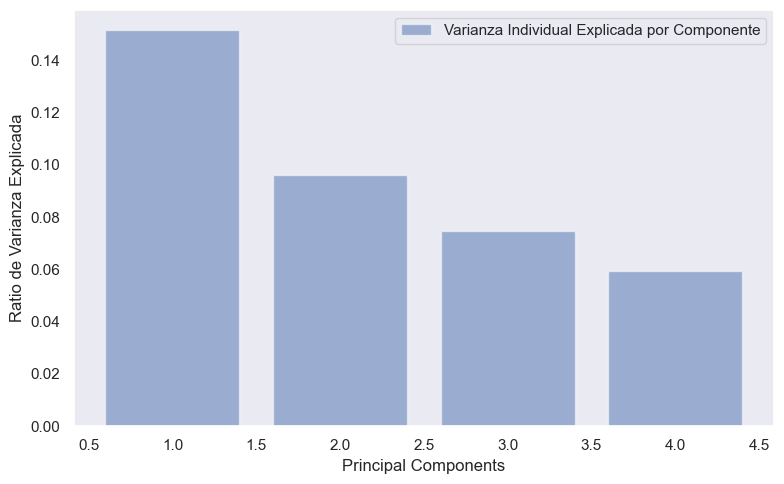

In [16]:
random.seed(42)

#Identificamos las respectivas variables numéricas y categóricas
numeric_features = dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_features = dataset.select_dtypes(include=['object', 'category']).columns

#Ajustamos escala (variables numéricas) y hacemos encoding (variables categóricas)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

#Ajuste y transformación
data_processed = preprocessor.fit_transform(dataset)

#Aplicamos Principal Component Analysis a 4 componentes
pca = PCA(n_components=4)
principal_components = pca.fit_transform(data_processed)

#Creamos DataFrame para los componentes
principal_df = pd.DataFrame(data=principal_components, columns=['PC 1', 'PC 2', 'PC3', 'PC4'])

#Nombres de los componentes
features_after_encoding = (preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features).tolist() + 
                           preprocessor.named_transformers_['cat'].get_feature_names_out().tolist())

#Features procesados
loadings = pd.DataFrame(data=pca.components_.T, columns=['PC 1', 'PC 2', 'PC3', 'PC4'], index=features_after_encoding)

#Visualización de los componentes
print(principal_df)

#Visualización features procesados
print("PCA Component Loadings:")
print(loadings)

#Ratio de Varianza Explicada
print("Ratio de Varianza Explicada:")
print(pca.explained_variance_ratio_)

#Visualización
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Varianza Individual Explicada por Componente')
plt.ylabel('Ratio de Varianza Explicada')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

La selección del número de 4 Componentes Principales parece razonable en tanto que explicamos una parte importante del dataset y, como podemos ver, la contribución de los componentes siguientes comienza a ser marginal.

Vemos que los resultados obtenidos concuerdan bastante con el análisis previo. Así, las variables más importantes son, entre otras:

G3, G2, G1 (Notas)
age (Edad)
Medu y Fedu (Nivel Educativo Padres)
failures (Fracasos)
Dalc y Walc (Consumo de Alcohol)

A continuación, vamos a realizar unas pocas permutaciones adicionales y guardar las variables más relevantes en un documento CSV con el que trabajaremos posteriormente. 

   Medu  Fedu  G2  G3  G1  Walc  age  Dalc  freetime  absences
0     4     4   6   6   5     1   18     1         3         6
1     1     1   5   6   5     1   17     1         3         4
2     1     1   8  10   7     3   15     2         3        10
3     4     2  14  15  15     1   15     1         2         2
4     3     3  10  10   6     2   16     1         3         4


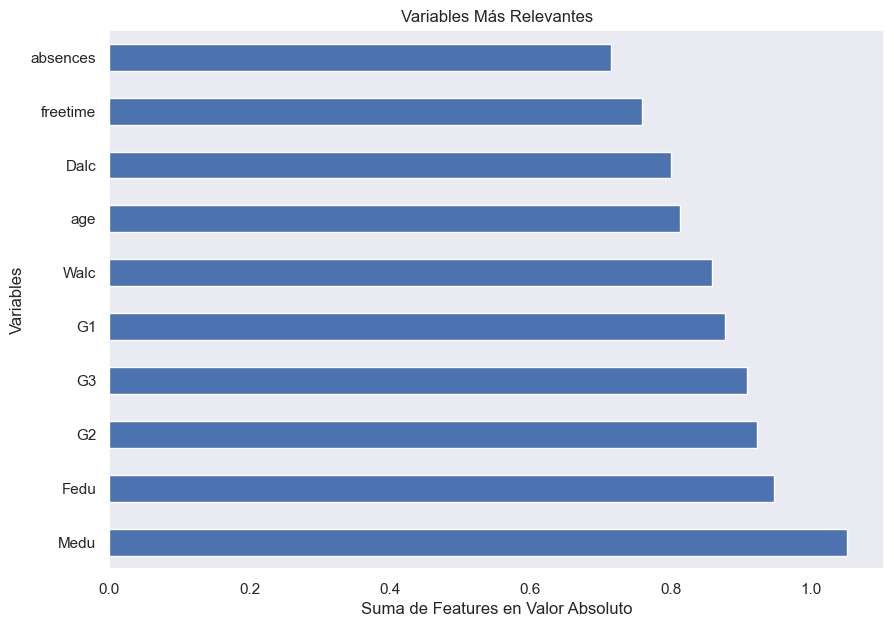

In [17]:
random.seed(42)

numeric_features = dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_features = dataset.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

data_processed = preprocessor.fit_transform(dataset)
features_after_encoding = preprocessor.transformers_[0][1].get_feature_names_out(numeric_features).tolist() + \
                          preprocessor.transformers_[1][1].get_feature_names_out().tolist()

pca = PCA(n_components=4)
pca.fit(data_processed)

loadings = pd.DataFrame(data=pca.components_.T, columns=[f'PC{i+1}' for i in range(4)], index=features_after_encoding)

loadings['Suma de Features en Valor Absoluto'] = loadings.abs().sum(axis=1)

top_variables = loadings.nlargest(10, 'Suma de Features en Valor Absoluto').index.tolist()

#Decodificación de variables
original_feature_names = [name.split('_')[0] for name in top_variables if '_' in name] + \
                         [name for name in top_variables if '_' not in name]

top_features_data = dataset[original_feature_names]


top_features_data.to_csv('dataset_cleaned.csv', index=False)

print(top_features_data.head())

plt.figure(figsize=(10, 7))
loadings['Suma de Features en Valor Absoluto'].nlargest(10).plot(kind='barh')
plt.title('Variables Más Relevantes')
plt.xlabel('Suma de Features en Valor Absoluto')
plt.ylabel('Variables')
plt.show()

Podemos plantear el siguiente Sistema Experto:

Ante todo, tenemos que tener en cuenta que hay una serie de variables estructurales en las que no podemos influir.

Estas son:

Medu (Nivel educativo de la madre)
Fedu (Nivel educativo del padre)
age (Edad)

Tampoco podemos influir de forma directa ni en G1 (Primer Período) ni en G2 (Segundo Período).

Por otra parte, nuestra variable objetivo es G3 (Nota Final).

Los factores que inciden en ella y en los que sí podemos influir son:

absences (ausencias: se trataría de reducir su número)
Dalc (consumo de alcohol entre semana)

Finalmente, los efectos de las variables freetime y Walc pueden ser un tanto ambiguos.

Con esto en mente, planteamos el modelo de Machine Learning.

Nos decantamos por Stocasting Gradient Boosting, dentro de Supervised Machine Learning.

Mean Squared Error: 0.16196197412939672
Feature Importances:
Medu: 0.003
Fedu: 0.009
G2: 0.770
G1: 0.030
Walc: 0.003
age: 0.030
Dalc: 0.005
freetime: 0.007
absences: 0.143


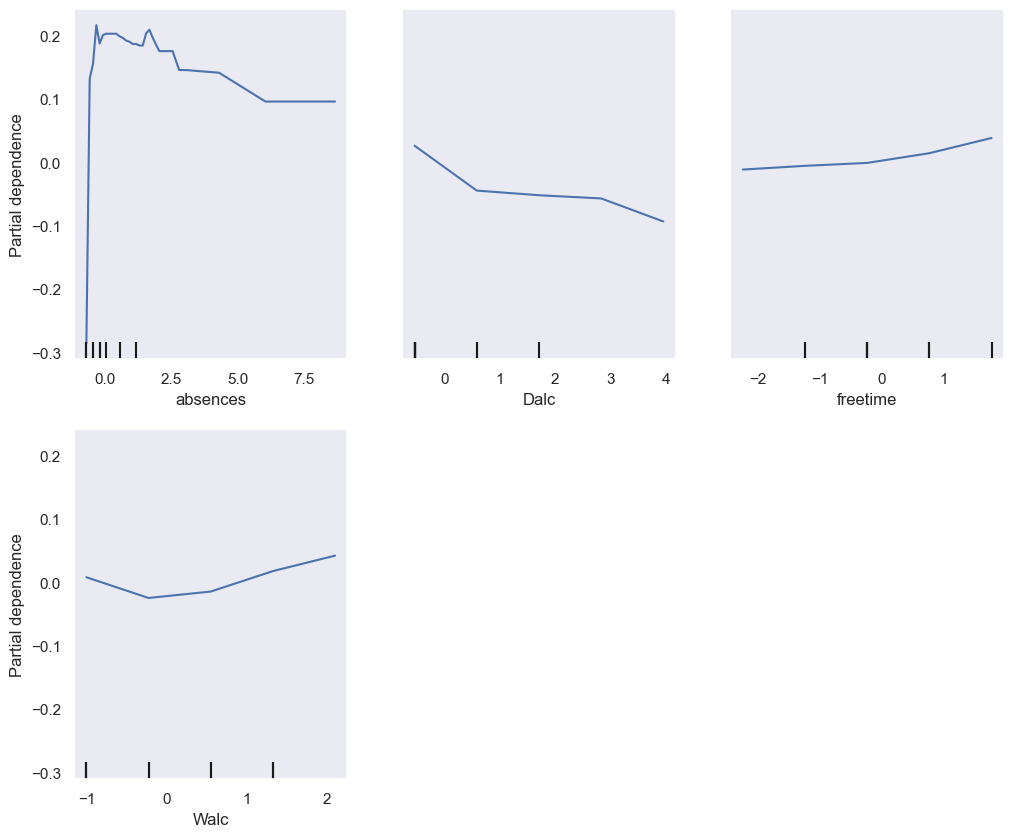

In [18]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv')

#Encoding de variables categóricas
label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

#Ajuste de escala de las variables numéricas
scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

#Separación del dataset en training y testing
X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Ajuste del modelo Stochastic Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42)
model.fit(X_train, y_train)

#Predicción y Evaluación
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

#Análisis de importancia de los features
feature_importance = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance:.3f}")
    
#Primera interpretación del modelo con dependency plots
features = ['absences', 'Dalc', 'freetime', 'Walc'] 
fig, ax = plt.subplots(figsize=(12, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax)
plt.show()

Resultados:

Vemos que MSE es bastante bajo, lo que indica el modelo Stochastic Gradient es un buen modelo.

En cuanto a feature importances, tenemos que G2 (Segundo Período) es la variable predictiva más relevante (valor de 0.77), si bien no podemos influir en ella de forma directa. En cuanto a los features sobre los que sí podemos tener control, podemos destacar absences (ausencias, con un valor de 0.14). Por tanto, podríamos mejorar el rendimiento final si conseguimos tener menos ausencias, algo que concuerda con la expertise planteada al inicio.

Esto se confirma también en los dependency plots: podemos ver el relativemente fuerte impacto de las ausencias. Dalc (consumo de alcohol entre semana) tiene algo de influencia, pero muy poca en términos comparativos.

Podemos plantear otro modelo de Supervised Machine Learning a efectos de contrastar e intentar mejorar los resultados.

Teniendo en cuenta que no podemos plantear feature importances o dependency plots en caso de Support Vector Machines (debido a su estructura) y disponiendo de un dataset pequeño, podemos optar por Random Forest:

Mean Squared Error: 0.15273262437119808
Feature Importances:
Medu: 0.008
Fedu: 0.016
G2: 0.797
G1: 0.016
Walc: 0.008
age: 0.029
Dalc: 0.004
freetime: 0.008
absences: 0.114


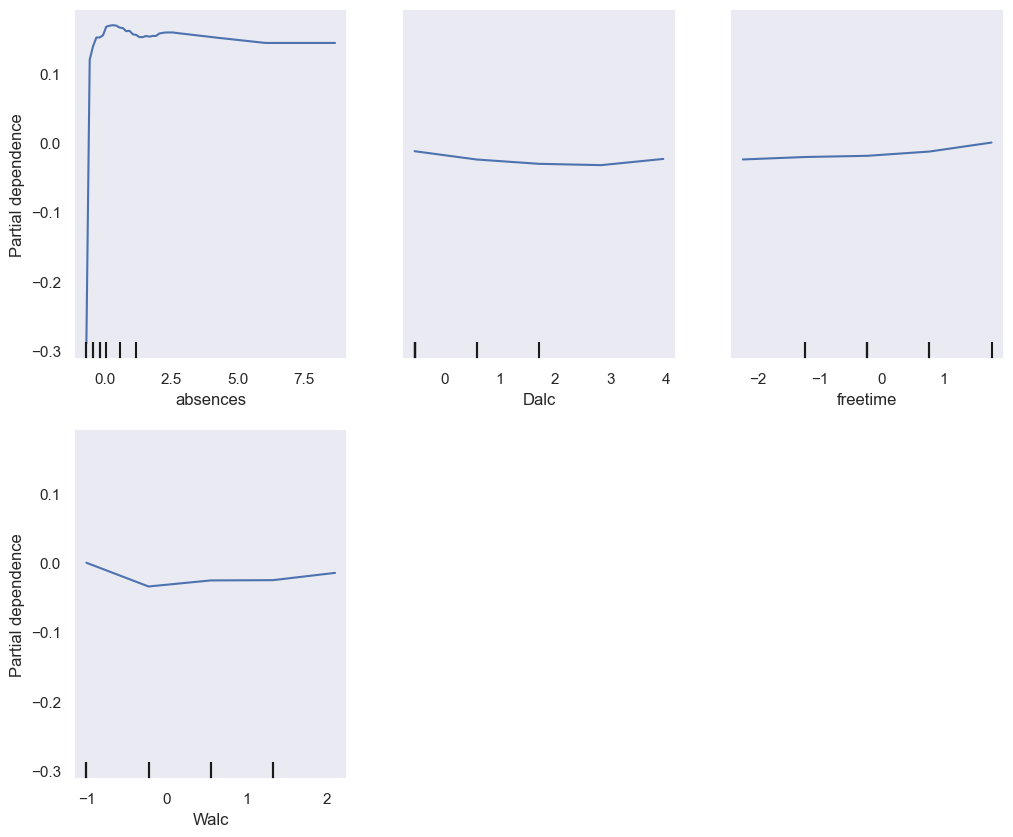

In [19]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv')

label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Ajuste del modelo Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

feature_importance = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance:.3f}")

features = ['absences', 'Dalc', 'freetime', 'Walc'] 
fig, ax = plt.subplots(figsize=(12, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features, ax=ax)
plt.show()

Obtenemos unos resultados muy similares:

MSE es muy ligeramente más bajo, de 0.15, lo que nos indica que Random Forest es un modelo marginalmente mejor en su conjunto que Stochastic Gradient Boosting.

En cuanto a features, tenemos que Random Forest otorga aún más importancia a G2 (Segundo Período, igual a 0.8). Con respecto a absences, la única variable significativa en la cual podemos influir a nivel de Sistema Experto, su relevancia es algo más baja aquí, de 0.11.

Tanto por el hecho de que Random Forest es un método usado demasiado frecuentemente como porque tenemos más margen de maniobra con el modelo anterior, nos vamos a quedar con Stochastic Gradient Boosting, es decir, el modelo anterior.

A continuación, vamos a plantear código para LIME y comentar este enfoque de Interpretable Machine Learning:

Mean Squared Error: 0.16196197412939672


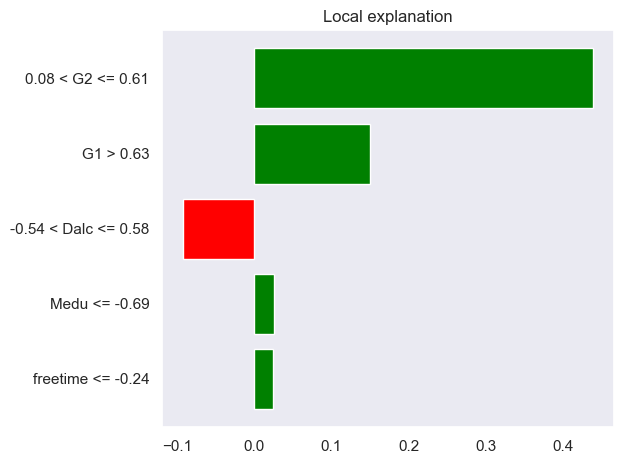

In [20]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv') 

label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Como hemos dicho, nos quedamos con Stochastic Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

#Definimos función para evitar un warning debido a que LIME permuta los datos de forma interna
def model_predict(data_as_array):
    data_as_df = pd.DataFrame(data_as_array, columns=X_train.columns)
    return model.predict(data_as_df)

#Explicador LIME
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X.columns,
                                 class_names=['G3'],
                                 mode='regression')

#Explicación de predicciones
i = 1
exp = explainer.explain_instance(X_test.iloc[i].values, model_predict, num_features=5)

#Visualizacion de la explicación
fig = exp.as_pyplot_figure()
fig.tight_layout()
plt.show()

En el caso de LIME, cabe tener en cuenta que es un enfoque post-hoc (la evaluación se realiza una vez que se tienen los resultados), agnóstico (se adapta a cualquier algoritmo de Machine Learning previo: en este caso, Stochastic Gradient Boosting) y local (no se generaliza a la totalidad de la distribución).

Para mayor adaptabilidad al lector, hemos fijado el paramétro de Explicación de Predicciones a 1. Es decir, planteamos una única regresión. Si bien es perfectamente posible elaborar más regresiones, cada vez que quisieramos simular código nos aparecería un resultado diferente. Luego, no habría concordancia con la explicación que aquí se da.

Así pues, vemos que G2 (Segundo Período) y, en menor medida, G1 (Primer Período) y Medu (Nivel Educativo de la Madre) son los features que determinan un mejor resultado final (mayor G3, Nota Final).

Por otra parte, absences (ausencias) y Walc (consumo de alcohol los fines de semana) disminuyen el rendimiento final.

Esta interpretación nos permite ampliar la expertise inicial, donde no estábamos del todo seguros sobre el impacto de la variable Walc. Gracias al método LIME, podemos extender nuestra expertise y afirmar que no sólo influyen negativamente las ausencias y Dalc (consumo de alcohol entre semana), sino que también lo hace Walc (consumo de alcohol entre los fines de semana).

Como desventajas del LIME, podemos mencionar que se trata de una métrica basada en la distribución normal y, al ser una regresión, las relaciones que se plantean son lineales.

Procedemos a continuación con SHAP:

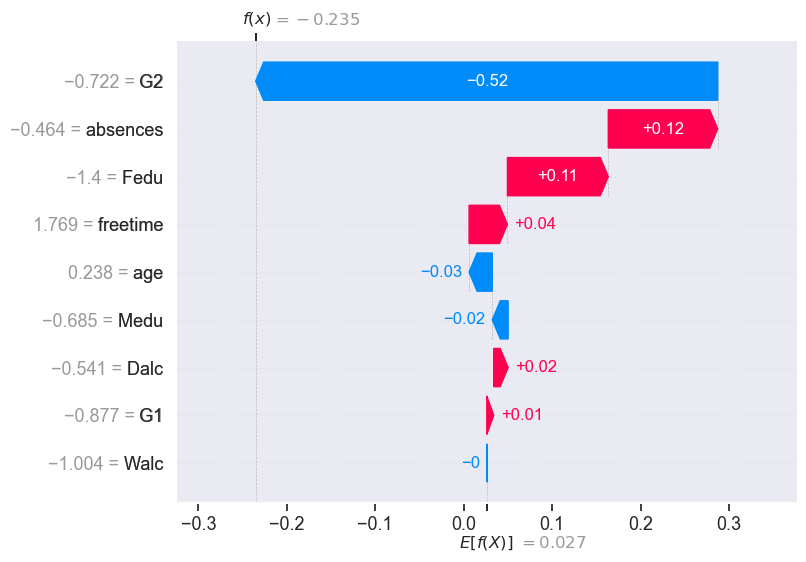

In [21]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv') 

label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42)
model.fit(X_train, y_train)

#Inicialización de SHAP
explainer = shap.Explainer(model, X_train)

#Cálculos de las Shapley Values
shap_values = explainer(X_test, check_additivity=False)

#Visualización de las Shapley Values para la primera predicción
shap.plots.waterfall(shap_values[0])

SHAP es un método originado en base al trabajo de Lloyd Shapley en teoría de juegos cooperativos.

En contexto de Machine Learning, el juego es la tarea de predicción que hemos realizado (en este caso, con Stochastic Gradient Boosting), los jugadores son los features que hemos utilizado, y la matriz de pagos sería el resultado obtenido.
    
La lógica de SHAP es la siguiente:

1 - En primer lugar, simulamos todas las interacciones posibles entre las diferentes variables. La simulación es de carácter exponencial (es el mínimo de interacciones, es decir 2, elevado a n posibilidades). Evidentemente, tendríamos un problema a nivel computacional si la cantidad de variables fuese muy grande, si bien no es el caso en nuestro dataset.

2 - En segundo lugar, teniendo en cómputo todas las interacciones posibles entre variables que se pueden dar, computamos la media (ponderada) para cada variable (sujeta al total de interacciones).

SHAP se considera un método más robusto que LIME, puesto que tenemos una generalización (a diferencia de una regresión local) y hay más riqueza de datos.

Así pues, en cuanto a interpretación de resultados concretos, tenemos que absences (ausencias) y Fedu (nivel educativo del padre) tienen mayor relevancia que la predicha en el modelo original (Stochastic Gradient Boosting), mientras que G2 (Segundo Período) tiene una importancia significativamente menor. 

A efectos prácticos, podríamos por ejemplo asignar un mayor peso a la variable absences (ausencias) para reflejar de una forma más certera su mayor relevancia.

Deep Learning:

En el contexto de nuestro dataset, lo que nos pueden aportar las técnicas de Deep Learning son, sobre todo, un mejor manejo de las relaciones no lineales y un mejor aprendizaje en cuanto a cómo se representan los diferentes features.

Así pues, podemos proponer un modelo de redes neuronales con la función de activación relu:

In [22]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv') 

label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Construcción de la red neuronal con el optimizador adam
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

#Entrenamiento de modelo, donde epochs es el número de iteraciones
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

#Evaluación y predicción
mse = model.evaluate(X_test, y_test)
print(f'Test MSE: {mse}')

predictions = model.predict(X_test)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.8269 - val_loss: 0.4055
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4507 - val_loss: 0.2732
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2844 - val_loss: 0.2814
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2110 - val_loss: 0.2307
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2056 - val_loss: 0.1917
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1237 - val_loss: 0.1710
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1316 - val_loss: 0.1700
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1079 - val_loss: 0.1686
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1012 - val_loss: 0.1611
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1078 - val_loss: 0.1591
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0972 - val_loss: 0.1667
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0693 - val_loss: 0.1668
Epoch 13/50

Habiendo hecho diferentes ajustes de epochs, obtenemos un MSE de 0.17 con 50 epochs. Por otra parte, no podemos computar feature importances debido a que la estructura no es una basada en árboles de decisión. El resultado previo está casi a la par con el del obtenido con Stochastic Gradient Boosting (igual a 0.16), si bien no lo mejora. La explicación puede estar en el hecho de que nuestro dataset no es lo suficientemente complejo como para que haya necesidad clara de recurrir a métodos de Deep Learning. No obstante, vamos a probar a continuación el método de Long Short-Term Memory (LSTM):

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.9595 - val_loss: 0.6742
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8596 - val_loss: 0.5872
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7253 - val_loss: 0.4988
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5930 - val_loss: 0.4183
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4857 - val_loss: 0.3432
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3903 - val_loss: 0.2793
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2663 - val_loss: 0.2318
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2617 - val_loss: 0.2018
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2248 - val_loss: 0.1863
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1677 - val_loss: 0.1802
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1413 - val_loss: 0.1763
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1912 - val_loss: 0.1767
Epoch 13/5

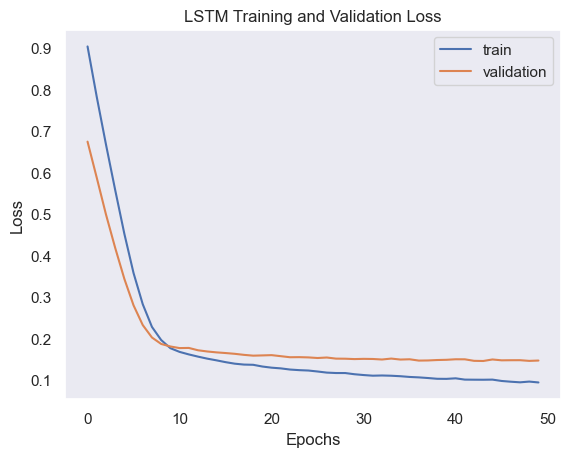

In [23]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv') 

label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Formateamos los datos de forma acorde con LSTM
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

#Construcción del modelo LSTM
model_lstm = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])), 
    LSTM(50),
    Dense(20, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(X_train_reshaped, y_train, epochs=50, validation_split=0.2)

mse_lstm = model_lstm.evaluate(X_test_reshaped, y_test)
print(f'Test MSE: {mse_lstm}')

predictions_lstm = model_lstm.predict(X_test_reshaped)

plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='validation')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

El método de LSTM consiste, esencialmente, en un pipe (Long Memory) que se controla a través del mecanismo de Short-Term Memory a efectos de evitar o bien gradient vanishing o bien gradient explosion, una problemática común en Deep Learning. Al mismo tiempo, los datos se presentan de forma secuencial.

Obtenemos un MSE mejor (más bajo) mediante LSTM, de 0.20 en 50 epocs (que parece ser el número de iteraciones óptimo, siendo los otros epochs probados 25 y 100).

Este resultado sigue sin mejorar el obtenido por Stochastic Gradient Boosting. Por otra parte, no tendría sentido recurrir a Convolutional Neural Networks (CNNs) puesto que se utilizan normalmente en otro dominio (procesamiento de imágenes).

Puesto que ni LIME ni SHAP están planteados para trabajar con datos secuenciales (están optimizados para datos tabulares o imagenes), vamos a plantear la interpretabilidad para la Red Neuronal anterior:

In [24]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv') 

label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Construcción de la red neuronal con el optimizador adam
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')

#Entrenamiento de modelo, donde epochs es el número de iteraciones
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

#Evaluación y predicción
mse = model.evaluate(X_test, y_test)
print(f'Test MSE: {mse}')

predictions = model.predict(X_test)

#Ajuste de formato
def nn_predict(input_data):
    return model.predict(input_data).flatten() 

#Inicialización de LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression'
)

#Explicación de la primera instancia
instance_index = 0
exp = explainer.explain_instance(
    data_row=X_test.iloc[instance_index].values, 
    predict_fn=nn_predict, 
    num_features=5  
)

exp.show_in_notebook(show_table=True)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.8303 - val_loss: 0.4030
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3899 - val_loss: 0.2769
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3137 - val_loss: 0.2777
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2189 - val_loss: 0.2270
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1977 - val_loss: 0.1903
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1469 - val_loss: 0.1814
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1275 - val_loss: 0.1664
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1268 - val_loss: 0.1654
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1046 - val_loss: 0.1627
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0933 - val_loss: 0.1598
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1012 - val_loss: 0.1549
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0809 - val_loss: 0.1629
Epoch 13

Si bien, como hemos visto anteriormente, las redes neuronales no nos ofrecen la mejor predicción posible, si son bastante ilustrativas a efectos de interpretabilidad.

Así, debido a su naturaleza de capas múltiples, podemos ver que tanto G1 (Primer Período) como G2 (Segundo Período) parecen estar muy ligeramente sobreestimados respecto a los valores obtenidos sin este enfoque interpretable. Nuevamente, cabe matizar que en el marco de nuestro Sistema Experto no podemos ejercer influencia directa sobre ninguna de estas dos variables.

De esta forma, la conclusión que podemos sacar es que mientras que el MSE es ligeramente más alto en el caso de las Redes Neuronales, el ajuste parece ser más representativo, en tanto que hay muy poca diferencia entre el modelo LIME y el original.

In [25]:
random.seed(42)

dataset_cleaned = pd.read_csv('dataset_cleaned.csv')

label_encoders = {}
for column in dataset_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset_cleaned[column] = le.fit_transform(dataset_cleaned[column])
    label_encoders[column] = le

scaler = StandardScaler()
numerical_cols = dataset_cleaned.select_dtypes(include=['int64', 'float64']).columns
dataset_cleaned[numerical_cols] = scaler.fit_transform(dataset_cleaned[numerical_cols])

X = dataset_cleaned.drop('G3', axis=1)
y = dataset_cleaned['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)
mse = model.evaluate(X_test, y_test)
print(f'Test MSE: {mse}')
predictions = model.predict(X_test)

predictions = model.predict(X_test)

#Utilizamos GradientExplainer en vez de DeepExplainer debido a falta de soporte de DeepExplainer en TensorFlow > 2.4.0
background = X_train.sample(min(100, len(X_train)))
explainer = shap.GradientExplainer(model, background)

test_sample = X_test.sample(min(100, len(X_test)))
test_sample_features = test_sample.values
shap_values = explainer.shap_values(test_sample_features)

print(shap_values)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9108 - val_loss: 0.3988
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4264 - val_loss: 0.2757
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2822 - val_loss: 0.2709
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1981 - val_loss: 0.2328
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1615 - val_loss: 0.1894
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1447 - val_loss: 0.1747
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1302 - val_loss: 0.1629
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0941 - val_loss: 0.1711
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1336 - val_loss: 0.1580
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0910 - val_loss: 0.1657
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0778 - val_loss: 0.1626
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0709 - val_loss: 0.1680
Epoch 13/50


Debido a la naturaleza secuencial de los datos y la utilización de una versión de TensorFlow > 2.4.0 no resulta posible conseguir una representación gráfica. En cualquier caso, observando los resultados vemos como en un modelo SHAP (que, como hemos explicado antes, ofrece una mejor generalización de datos) la desviación entre el modelo SHAP y el modelo original (de Redes Neuronales) es muy pequeña.

Como conclusión general de interpretabilidad en Deep Learning, podemos concluir que para este dataset en concreto, los modelos de Machine Learning ofrecen un ajuste más exacto pero son también más proclives a subestimar o sobreestimar la importancia de determinados features, mientras que en los modelos de Deep Learning ocurre lo opuesto.

Nota final: para una mejor comprensión de los modelos LIME y SHAP se han utilizado de referencia los respectivos epígrafes del capítulo "Local Model-Agnostic Methods" del libro Interpretable Machine Learning de Christoph Molnar (2022, 2ª Edición).